In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoLarsCV, RidgeCV, PoissonRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

pd.set_option("display.max_columns", 100)
plt.style.use('bmh')

def mean_absolute_percentage_error(y_true, y_pred):
    error = y_true - y_pred
    return np.mean(np.abs(error / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def root_mean_squared_percentage_error(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100

def date_parser(date):
    return pd.to_datetime(date, format="%d/%m/%Y")

In [2]:
train = pd.read_csv("train.csv", low_memory=False, date_parser=date_parser, parse_dates=['Date'])
test = pd.read_csv("test.csv", low_memory=False, date_parser=date_parser, parse_dates=['Date'])
stores = pd.read_csv("store.csv", low_memory=False)

In [3]:
print(f"Shapes: Train={train.shape}\tTest={test.shape}\tStores={stores.shape}")
print("Start Prediction on: {1}\nEnd   Prediction on: {0}".format(test.Date.max(), test.Date.min()))

Shapes: Train=(1017209, 9)	Test=(41088, 9)	Stores=(1115, 10)
Start Prediction on: 2015-08-01 00:00:00
End   Prediction on: 2015-09-17 00:00:00


In [4]:
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
test.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,4,2015-09-17,NaN,NaN,1.0,1,0,0
1,3,4,2015-09-17,NaN,NaN,1.0,1,0,0
2,7,4,2015-09-17,NaN,NaN,1.0,1,0,0
3,8,4,2015-09-17,NaN,NaN,1.0,1,0,0
4,9,4,2015-09-17,NaN,NaN,1.0,1,0,0


### 1. Basic Statistics
- Try to discover any outliers with basic statistics.

In [7]:
stores.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [8]:
train.describe().apply(round, axis=1, args=(3,))

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000,1017209.000
mean,558.430,3.998,5773.819,633.146,0.830,0.382,0.179
std,321.909,1.997,3849.926,464.412,0.376,0.486,0.383
min,1.000,1.000,0.000,0.000,0.000,0.000,0.000
25%,280.000,2.000,3727.000,405.000,1.000,0.000,0.000
50%,558.000,4.000,5744.000,609.000,1.000,0.000,0.000
75%,838.000,6.000,7856.000,837.000,1.000,1.000,0.000
max,1115.000,7.000,41551.000,7388.000,1.000,1.000,1.000


In [9]:
test.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,0.0,0.0,41077.000000,41088.000000,41088.000000
mean,555.899533,3.979167,NaN,NaN,0.854322,0.395833,0.443487
std,320.274496,2.015481,NaN,NaN,0.352787,0.489035,0.496802
min,1.000000,1.000000,NaN,NaN,0.000000,0.000000,0.000000
25%,279.750000,2.000000,NaN,NaN,1.000000,0.000000,0.000000
50%,553.500000,4.000000,NaN,NaN,1.000000,0.000000,0.000000
75%,832.250000,6.000000,NaN,NaN,1.000000,1.000000,1.000000
max,1115.000000,7.000000,NaN,NaN,1.000000,1.000000,1.000000


#### 1.1 Outliers from Basic Statistics
- Train and Test set doesn't seem to contain any impossible values on the first glance.
- The dataset of stores though have a strange year. We will replace this with more probable values.
- We will replace the competitions earlier than 1990 from: (1961 and 1900) with (1989 and 1984) std=6.19.

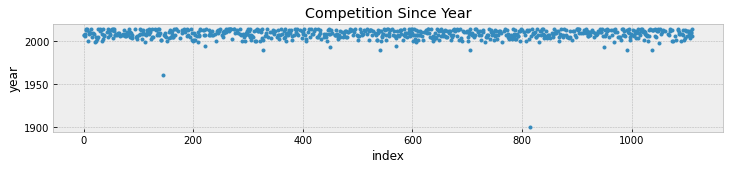

In [10]:
stores.CompetitionOpenSinceYear.plot(figsize=(12,2), lw=0, marker='.', ls='')
plt.xlabel('index'); plt.ylabel('year'); plt.title("Competition Since Year");

In [11]:
2008 - 4*6.19

1983.24

In [12]:
print("10 Earlier Competitions:", sorted(stores.CompetitionOpenSinceYear.unique())[:10])

10 Earlier Competitions: [1900.0, 1961.0, 1990.0, 1994.0, 1995.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0]


In [13]:
stores.CompetitionOpenSinceYear.replace([1961.0, 1900.0], [1989, 1983], inplace=True) 

### 2. Clean Stores
- Stores of train and test set must be consistent.

In [14]:
# Check whether we have the same stores in the test and train set
train.Store.nunique(), test.Store.nunique()

(1115, 856)

In [15]:
# Check all test Stores exist in train set
stores_not_in_train_set = []
unique_train_stores = train.Store.unique()
for store in test.Store.unique():
    if store not in unique_train_stores:
        stores_not_in_train_set.append(store)
print("Stores not in train set:", stores_not_in_train_set)

Stores not in train set: []


In [16]:
# Check stores in train set not existed in test set
stores_not_in_test_set = []
unique_test_stores = test.Store.unique()
for store in train.Store.unique():
    if store not in unique_test_stores:
        stores_not_in_test_set.append(store)
print("Stores not in test set:", stores_not_in_test_set)
print(f"\nRESULT: There are {len(stores_not_in_test_set)} stores in train set not existed in test set.")

Stores not in test set: [2, 4, 5, 6, 17, 18, 26, 28, 34, 37, 44, 54, 55, 57, 59, 60, 65, 78, 85, 87, 88, 95, 96, 97, 103, 104, 106, 114, 116, 121, 123, 125, 133, 134, 138, 148, 151, 156, 163, 167, 173, 177, 178, 185, 196, 198, 203, 205, 208, 211, 222, 223, 225, 232, 236, 237, 240, 257, 260, 261, 264, 266, 270, 271, 276, 282, 286, 291, 292, 293, 307, 313, 318, 321, 322, 324, 327, 332, 349, 357, 360, 361, 363, 366, 374, 375, 376, 381, 382, 384, 390, 396, 400, 401, 402, 419, 423, 436, 437, 438, 439, 443, 444, 454, 460, 462, 464, 469, 474, 476, 478, 479, 480, 482, 483, 489, 494, 496, 503, 513, 523, 525, 526, 544, 546, 556, 559, 560, 569, 576, 583, 594, 595, 596, 599, 606, 607, 608, 609, 613, 614, 617, 626, 630, 634, 635, 648, 649, 652, 654, 664, 668, 672, 679, 682, 683, 686, 688, 698, 704, 708, 709, 715, 726, 730, 735, 743, 745, 747, 754, 755, 760, 761, 779, 780, 781, 783, 786, 787, 788, 794, 798, 808, 812, 814, 817, 821, 827, 828, 830, 834, 836, 838, 839, 841, 843, 854, 869, 870, 873, 876

In [17]:
# clean train set from the stores above
train.drop(train[train.Store.isin(stores_not_in_test_set)].index, inplace=True)
print("New Shape:", train.shape)

New Shape: (773231, 9)


### 3. Handle Missing values
- Regression models cannot handle missing values, so they must be handled.

In [18]:
train.isna().sum() # Train Set has not any NaN

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [19]:
test.isna().sum() # We have to treat the Open variable

Store                0
DayOfWeek            0
Date                 0
Sales            41088
Customers        41088
Open                11
Promo                0
StateHoliday         0
SchoolHoliday        0
dtype: int64

In [20]:
stores.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [21]:
test.Store[test.Open.isna()] # The NaN of Open in test correspond to one store the 622

479      622
1335     622
2191     622
3047     622
4759     622
5615     622
6471     622
7327     622
8183     622
9039     622
10751    622
Name: Store, dtype: int64

##### 3.1 Handle Open variable
- Test set misses 11 observations of store 622 about being open or not.
- We will use the train set to understand when Store 622 is open and when not.

In [22]:
train[(train.Store == 622) & (train.DayOfWeek == 7)].Open.unique()
# This line shows that store 622 is always closed on Sunday

array([0], dtype=int64)

In [23]:
train[(train.Store == 622) & (train.Open == 0) & (train.StateHoliday != '0')].Open.unique()
# The line above shows that store 622 is closed on StateHoliday.

array([0], dtype=int64)

In [24]:
test[test.Open.isna()]
# None of the NaN cases regards StateHoliday or Sunday so all NaN should be the positive class.

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
479,622,4,2015-09-17,NaN,NaN,NaN,1,0,0
1335,622,3,2015-09-16,NaN,NaN,NaN,1,0,0
2191,622,2,2015-09-15,NaN,NaN,NaN,1,0,0
3047,622,1,2015-09-14,NaN,NaN,NaN,1,0,0
4759,622,6,2015-09-12,NaN,NaN,NaN,0,0,0
5615,622,5,2015-09-11,NaN,NaN,NaN,0,0,0
6471,622,4,2015-09-10,NaN,NaN,NaN,0,0,0
7327,622,3,2015-09-09,NaN,NaN,NaN,0,0,0
8183,622,2,2015-09-08,NaN,NaN,NaN,0,0,0
9039,622,1,2015-09-07,NaN,NaN,NaN,0,0,0


In [25]:
test.Open.fillna(1, inplace=True)  # Fill NaN

In [26]:
test.Open.isna().sum() # check fill nan, sum should be 0

0

##### 2.2 Handle Stores Missing Values
- Three (3) observations in stores' Competition Distance Variable are missing. 
- Also, information is missing about when competition opened from 354 stores.
- Also, information is missing from Promo variables.

    - We replace with the median value and empty string for NaN of Promo Interval

In [27]:
# Implement the above decisions
stores.CompetitionDistance.fillna(stores.CompetitionDistance.median(), inplace=True)
stores.CompetitionOpenSinceMonth.fillna(stores.CompetitionOpenSinceMonth.median(), inplace=True)
stores.CompetitionOpenSinceYear.fillna(stores.CompetitionOpenSinceYear.median(), inplace=True)
stores.Promo2SinceWeek.fillna(39, inplace=True)
stores.Promo2SinceYear.fillna(2015, inplace=True)
stores.PromoInterval.fillna('', inplace=True)

In [28]:
test.Date[0], test.Date[0].week

(Timestamp('2015-09-17 00:00:00'), 38)

In [29]:
stores.CompetitionDistance.median(), stores.CompetitionOpenSinceMonth.median(), stores.CompetitionOpenSinceYear.median()

(2325.0, 8.0, 2010.0)

In [30]:
stores.isna().sum().sum() # stores should have now 0 NaN

0

### 3. Stores' Features Handling.
- Stores can combine features like Assortment + StoreType and generate an interaction.
- Time Features like month + year and week+year can be unified to one.
- Categories can be one-hot-encoded.
- The stores dataframe will be transformed to a dataframe with one-hot_encoded and numerical variables.
- The stores will be cleaned from stores not included in the test set.
- The Promo Intervals can be transformed into a collection appropriate for comparison with month numbers.

In [31]:
print(stores.shape)

(1115, 10)


In [32]:
stores['StoreTypeAssortment'] = stores.StoreType + "_" + stores.Assortment
stores['CompetitionOpenMonths'] = ((stores.CompetitionOpenSinceYear.max() - stores.CompetitionOpenSinceYear) * 12) \
                                  + stores.CompetitionOpenSinceMonth
stores['Promo2Weeks'] = ((stores.Promo2SinceYear.max() - stores.Promo2SinceYear) * 52 + stores.Promo2SinceWeek)

In [33]:
month_idx = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sept':9, 'Oct':10, 'Nov':11, 'Dec':12}

def transform_promo_interval(s):
    """Transform a string with comma separated month abbreviations to a list of months' numbers."""
    return [month_idx[m] for m in s.split(',')] if s else [0]
    
stores['PromoInterval'] = stores.PromoInterval.apply(transform_promo_interval)

In [34]:
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreTypeAssortment,CompetitionOpenMonths,Promo2Weeks
0,1,c,a,1270.0,9.0,2008.0,0,39.0,2015.0,[0],c_a,93.0,39.0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"[1, 4, 7, 10]",a_a,107.0,273.0
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"[1, 4, 7, 10]",a_a,120.0,222.0
3,4,c,c,620.0,9.0,2009.0,0,39.0,2015.0,[0],c_c,81.0,39.0
4,5,a,a,29910.0,4.0,2015.0,0,39.0,2015.0,[0],a_a,4.0,39.0


In [35]:
to_ohe = ['StoreType', 'Assortment', 'StoreTypeAssortment']
drop_storecols = 'CompetitionOpenSinceMonth	CompetitionOpenSinceYear Promo2SinceWeek	Promo2SinceYear'.split()
stores = pd.get_dummies(stores.drop(columns=drop_storecols), columns=to_ohe).set_index('Store').loc[unique_test_stores]

In [36]:
stores.head()

,CompetitionDistance,Promo2,PromoInterval,CompetitionOpenMonths,Promo2Weeks,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StoreTypeAssortment_a_a,StoreTypeAssortment_a_c,StoreTypeAssortment_b_a,StoreTypeAssortment_b_b,StoreTypeAssortment_b_c,StoreTypeAssortment_c_a,StoreTypeAssortment_c_c,StoreTypeAssortment_d_a,StoreTypeAssortment_d_c
Store,,,,,,,,,,,,,,,,,,,,,
1,1270.0,0,[0],93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
3,14130.0,1,"[1, 4, 7, 10]",120.0,222.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
7,24000.0,0,[0],28.0,39.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
8,7520.0,0,[0],22.0,39.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
9,2030.0,0,[0],188.0,39.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0


In [37]:
print("Stored Shape:", stores.shape)

Stored Shape: (856, 21)


### 4. Feature Extraction - Feature Generation
- processing can take place in one dataframe unifying test and train set.
- processing will also add the store features in the data.
- Datetime Features will be added.
- Year will be normalized
- New Features will be generated.
- Stores will be one-hot-encoded 

In [38]:
data = train.append(test).merge(stores, left_on='Store', right_index=True)
data.shape

(814319, 30)

In [39]:
data['Year'] = data.Date.apply(lambda date: date.year)
data['Year'] -= data.Year.min()
data['Month'] = data.Date.apply(lambda date: date.month)
data['Week'] = data.Date.apply(lambda date: date.week)
data['Day'] = data.Date.apply(lambda date: date.day)

In [40]:
data['IsPromo2'] = data.apply(lambda row: 1 if row.Month in row.PromoInterval else 0, axis=1)

In [41]:
print("Shape of data:", data.shape)
data

Shape of data: (814319, 35)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,Promo2,PromoInterval,CompetitionOpenMonths,Promo2Weeks,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StoreTypeAssortment_a_a,StoreTypeAssortment_a_c,StoreTypeAssortment_b_a,StoreTypeAssortment_b_b,StoreTypeAssortment_b_c,StoreTypeAssortment_c_a,StoreTypeAssortment_c_c,StoreTypeAssortment_d_a,StoreTypeAssortment_d_c,Year,Month,Week,Day,IsPromo2
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,1270.0,0,[0],93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,31,0
1115,1,4,2015-07-30,5020.0,546.0,1.0,1,0,1,1270.0,0,[0],93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,30,0
2230,1,3,2015-07-29,4782.0,523.0,1.0,1,0,1,1270.0,0,[0],93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,29,0
3345,1,2,2015-07-28,5011.0,560.0,1.0,1,0,1,1270.0,0,[0],93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,28,0
4460,1,1,2015-07-27,6102.0,612.0,1.0,1,0,1,1270.0,0,[0],93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37663,1115,3,2015-08-05,NaN,NaN,1.0,1,0,1,5350.0,1,"[3, 6, 9, 12]",68.0,178.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,2,8,32,5,0
38519,1115,2,2015-08-04,NaN,NaN,1.0,1,0,1,5350.0,1,"[3, 6, 9, 12]",68.0,178.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,2,8,32,4,0
39375,1115,1,2015-08-03,NaN,NaN,1.0,1,0,1,5350.0,1,"[3, 6, 9, 12]",68.0,178.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,2,8,32,3,0
40231,1115,7,2015-08-02,NaN,NaN,0.0,0,0,1,5350.0,1,"[3, 6, 9, 12]",68.0,178.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,2,8,31,2,0


In [42]:
drop_columns = ['PromoInterval', 'Customers']

In [43]:
store_idx = data.Store.values # keep stores as helper column

In [44]:
data = pd.get_dummies(data.drop(columns=drop_columns), columns=['Store', 'StateHoliday'])

In [45]:
data.insert(0, 'store_id', store_idx) # helper column

In [46]:
train = data.dropna()
test = data[data.Sales.isna()]

In [47]:
train.shape, test.shape

((773231, 892), (41088, 892))

In [48]:
train.head()

,store_id,DayOfWeek,Date,Sales,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,CompetitionOpenMonths,Promo2Weeks,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StoreTypeAssortment_a_a,StoreTypeAssortment_a_c,StoreTypeAssortment_b_a,StoreTypeAssortment_b_b,StoreTypeAssortment_b_c,StoreTypeAssortment_c_a,StoreTypeAssortment_c_c,StoreTypeAssortment_d_a,StoreTypeAssortment_d_c,Year,Month,Week,Day,IsPromo2,Store_1,Store_3,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,...,Store_1058,Store_1059,Store_1060,Store_1061,Store_1062,Store_1063,Store_1064,Store_1065,Store_1066,Store_1067,Store_1068,Store_1070,Store_1071,Store_1072,Store_1073,Store_1076,Store_1077,Store_1078,Store_1079,Store_1080,Store_1083,Store_1084,Store_1086,Store_1087,Store_1088,Store_1089,Store_1091,Store_1092,Store_1094,Store_1096,Store_1097,Store_1099,Store_1100,Store_1101,Store_1102,Store_1103,Store_1104,Store_1105,Store_1106,Store_1107,Store_1109,Store_1111,Store_1112,Store_1113,Store_1114,Store_1115,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,5,2015-07-31,5263.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,31,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1115,1,4,2015-07-30,5020.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2230,1,3,2015-07-29,4782.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,29,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3345,1,2,2015-07-28,5011.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4460,1,1,2015-07-27,6102.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,27,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [49]:
data

,store_id,DayOfWeek,Date,Sales,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,CompetitionOpenMonths,Promo2Weeks,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StoreTypeAssortment_a_a,StoreTypeAssortment_a_c,StoreTypeAssortment_b_a,StoreTypeAssortment_b_b,StoreTypeAssortment_b_c,StoreTypeAssortment_c_a,StoreTypeAssortment_c_c,StoreTypeAssortment_d_a,StoreTypeAssortment_d_c,Year,Month,Week,Day,IsPromo2,Store_1,Store_3,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,...,Store_1058,Store_1059,Store_1060,Store_1061,Store_1062,Store_1063,Store_1064,Store_1065,Store_1066,Store_1067,Store_1068,Store_1070,Store_1071,Store_1072,Store_1073,Store_1076,Store_1077,Store_1078,Store_1079,Store_1080,Store_1083,Store_1084,Store_1086,Store_1087,Store_1088,Store_1089,Store_1091,Store_1092,Store_1094,Store_1096,Store_1097,Store_1099,Store_1100,Store_1101,Store_1102,Store_1103,Store_1104,Store_1105,Store_1106,Store_1107,Store_1109,Store_1111,Store_1112,Store_1113,Store_1114,Store_1115,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,5,2015-07-31,5263.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,31,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1115,1,4,2015-07-30,5020.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2230,1,3,2015-07-29,4782.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,29,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3345,1,2,2015-07-28,5011.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4460,1,1,2015-07-27,6102.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,27,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37663,1115,3,2015-08-05,NaN,1.0,1,1,5350.0,1,68.0,178.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,2,8,32,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
38519,1115,2,2015-08-04,NaN,1.0,1,1,5350.0,1,68.0,178.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,2,8,32,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
39375,1115,1,2015-08-03,NaN,1.0,1,1,5350.0,1,68.0,178.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,2,8,32,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
40231,1115,7,2015-08-02,NaN,0.0,0,1,5350.0,1,68.0,178.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,2,8,31,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


### 5. EDA
- Exploratory Analysis may reveal insights about which features may prove valuable.
- Also may give ideas for further generation of features.

In [50]:
plt.style.use("fivethirtyeight")

#### 5.1 Summarize Sales

In [51]:
sales = train.set_index('Date')['Sales']

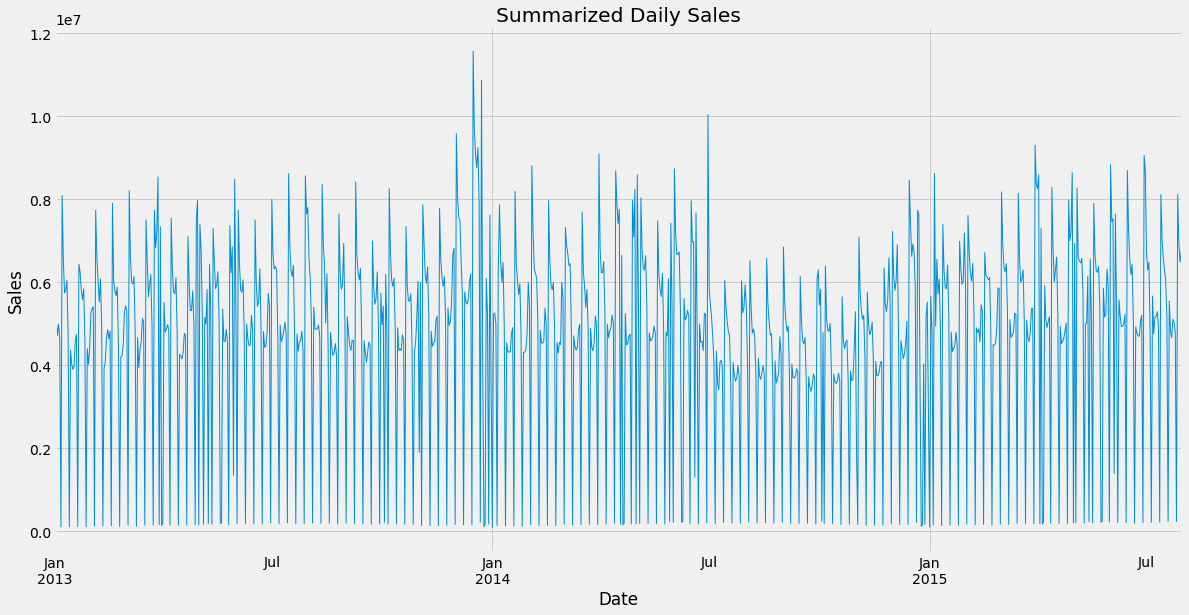

In [52]:
sales_daily = sales.resample('D').sum()
sales_daily.plot(figsize=(18, 9), lw=1)
plt.title("Summarized Daily Sales")
plt.ylabel('Sales');
plt.savefig('summarized_daily_sales.png', dpi=300)

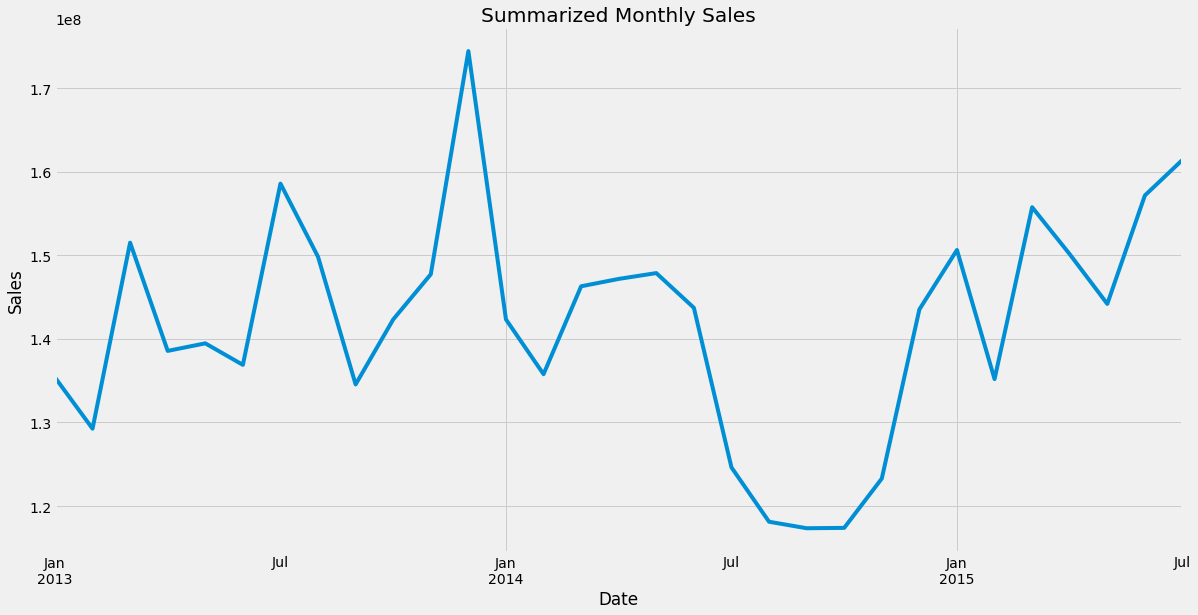

In [53]:
sales_monthly =sales.resample('M').sum()
plt.figure(figsize=(18, 9))
sales_monthly.plot()
plt.title("Summarized Monthly Sales")
plt.ylabel('Sales');
plt.savefig('summarized_monthy_sales.png', dpi=300)

#### 5.2 Association of Holidays

In [60]:
daily_resampled = train.set_index('Date').resample('D')
state_holiday_a = daily_resampled['StateHoliday_a'].sum()
state_holiday_b = daily_resampled['StateHoliday_b'].sum()
state_holiday_c = daily_resampled['StateHoliday_c'].sum()

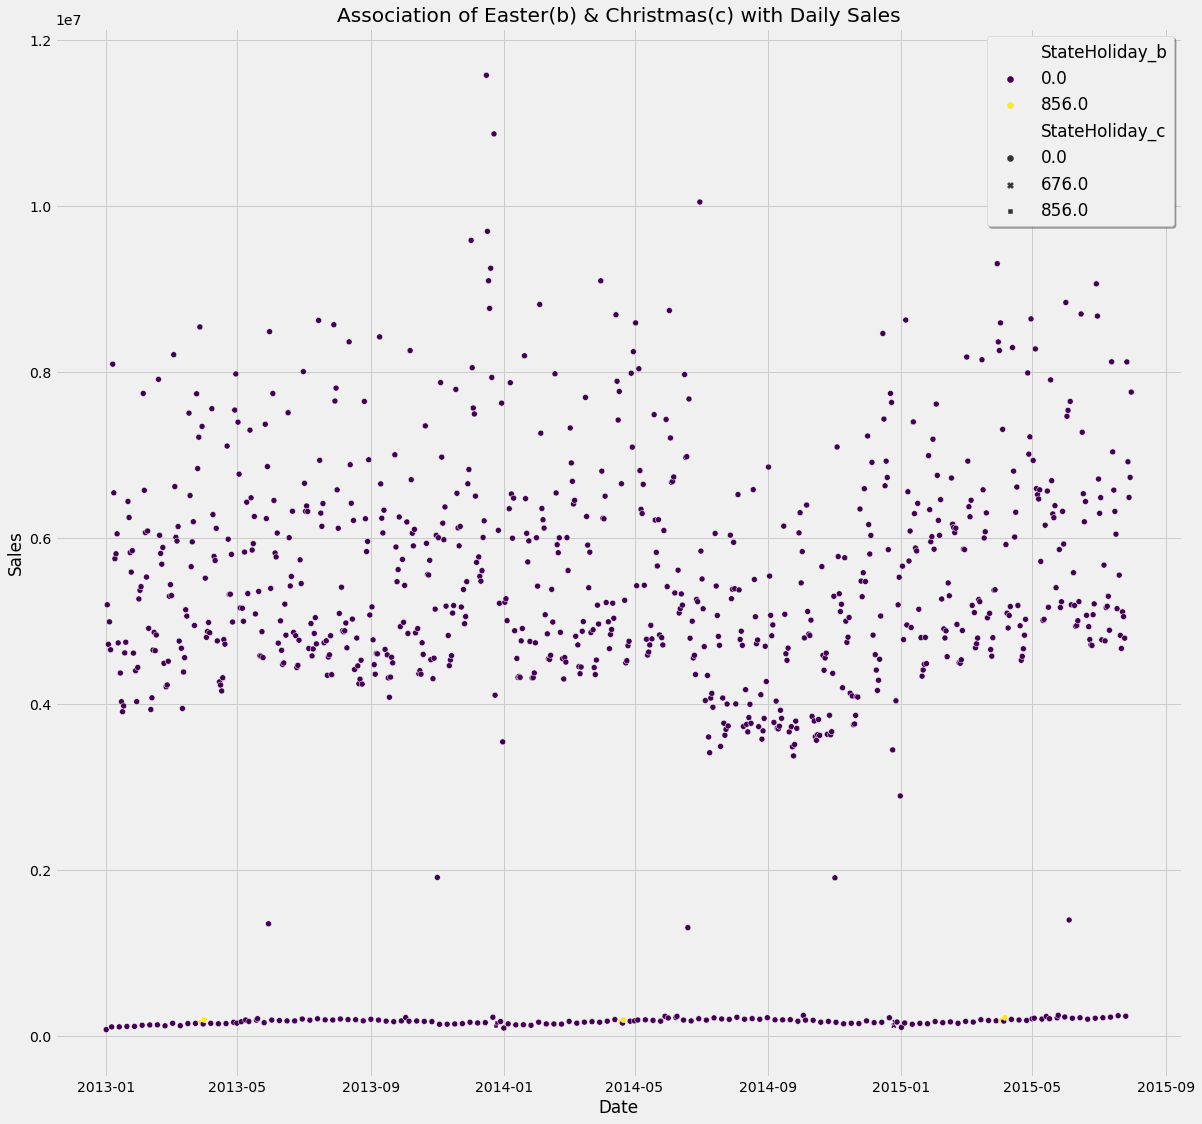

In [61]:
plt.figure(figsize=(18, 18))
sns.scatterplot(x=sales_daily.index, y=sales_daily.values, hue=state_holiday_b, style=state_holiday_c, palette='viridis')
plt.title("Association of Easter(b) & Christmas(c) with Daily Sales")
plt.legend(fontsize='large', shadow=True, fancybox=True, bbox_to_anchor=(1, 1, 0, 0))
plt.ylabel('Sales')
plt.xlabel('Date');
plt.savefig("association_of_stateholiday_with_sales.png", dpi=300, bbox_inches='tight')

#### 5.3 Association of Promotion

In [58]:
promo = daily_resampled['Promo'].sum()
promo2 = daily_resampled['Promo2'].sum()

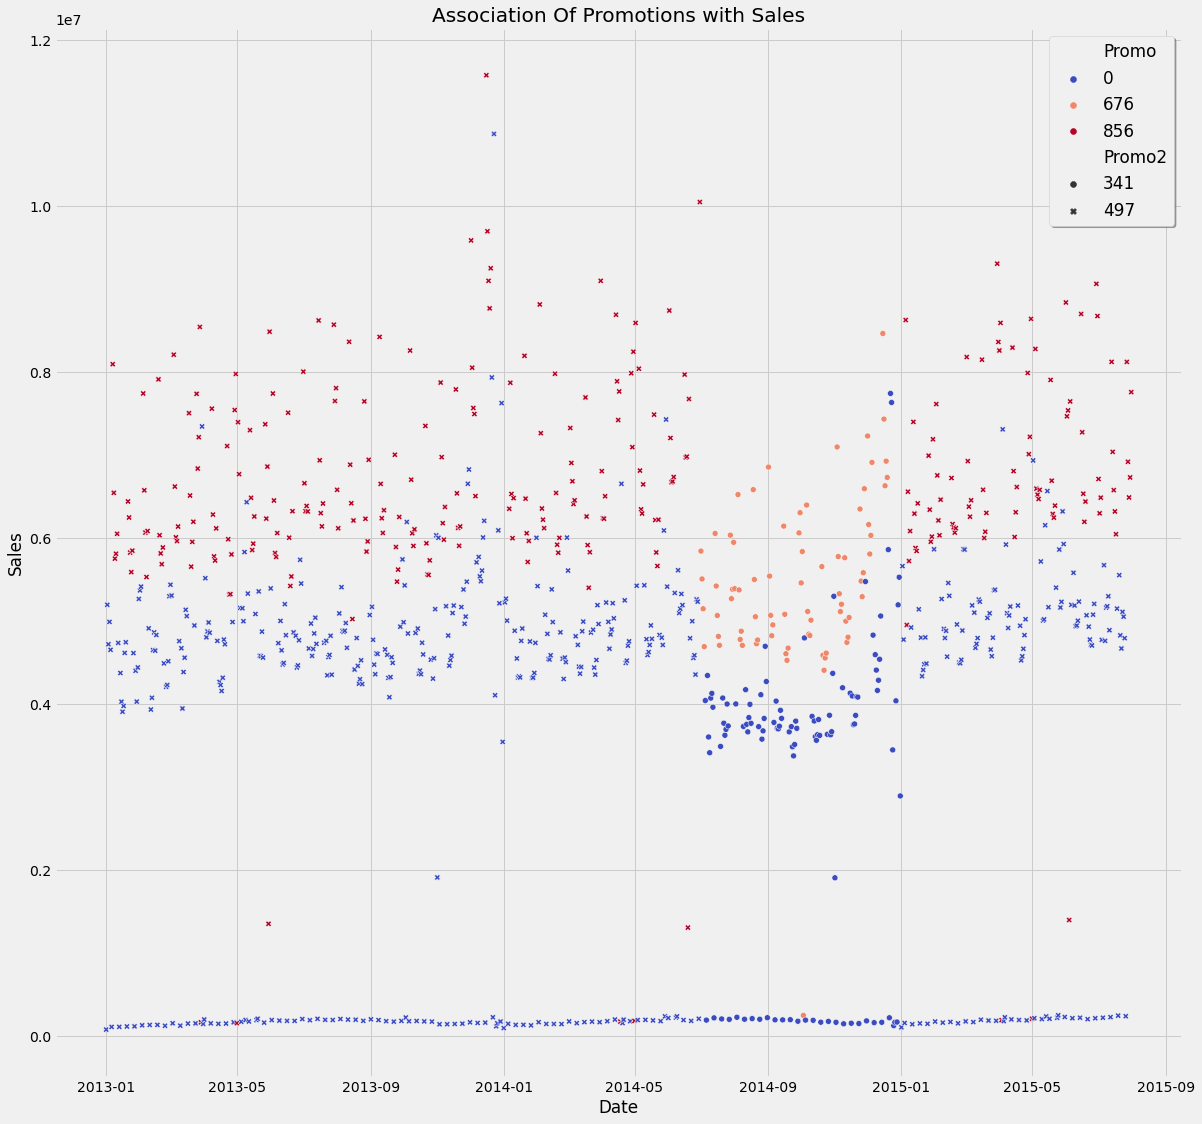

In [62]:
plt.figure(figsize=(18, 18))
sns.scatterplot(x=sales_daily.index, y=sales_daily.values, hue=promo, style=promo2, palette='coolwarm')
plt.title("Association Of Promotions with Sales")
plt.legend(fontsize='large', shadow=True, fancybox=True, bbox_to_anchor=(1, 1, 0, 0))
plt.ylabel('Sales')
plt.xlabel('Date')
plt.savefig("association_of_promotion_with_sales.png", dpi=300);

#### 5.3 Analyze Competition

In [63]:
competition_distance = train.groupby('store_id').agg({'Sales':'sum', 'CompetitionDistance':'mean'})

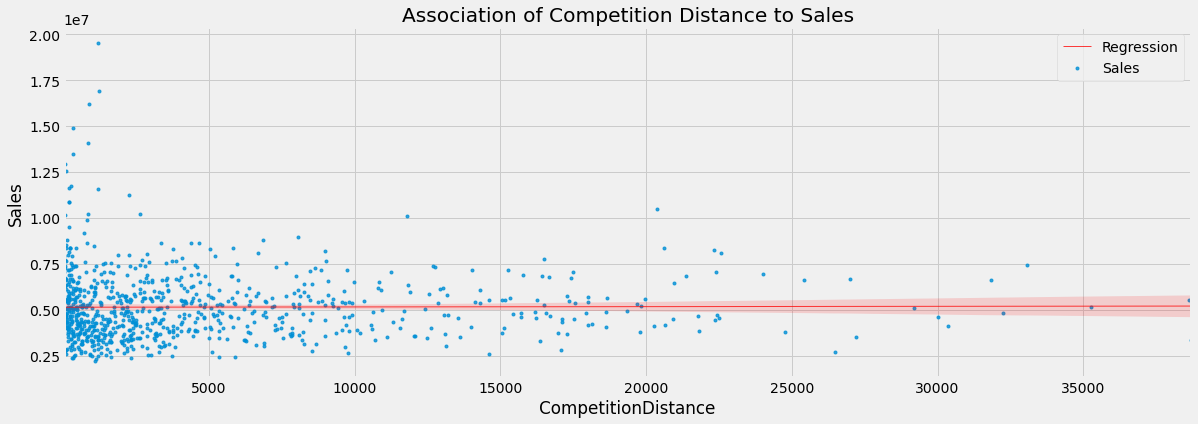

In [74]:
plt.figure(figsize=(18, 6))
sns.regplot(x="CompetitionDistance", y="Sales", 
            data=competition_distance[competition_distance.CompetitionDistance<40000],
            marker='.',
            line_kws={'label':'Regression', 'color':'red', 'alpha':0.75, 'lw':1},
            label='Sales'
            )
plt.legend()
plt.title("Association of Competition Distance to Sales")
plt.savefig("association_of_competition_distance_with_sales.png", dpi=300, bbox_inches='tight');

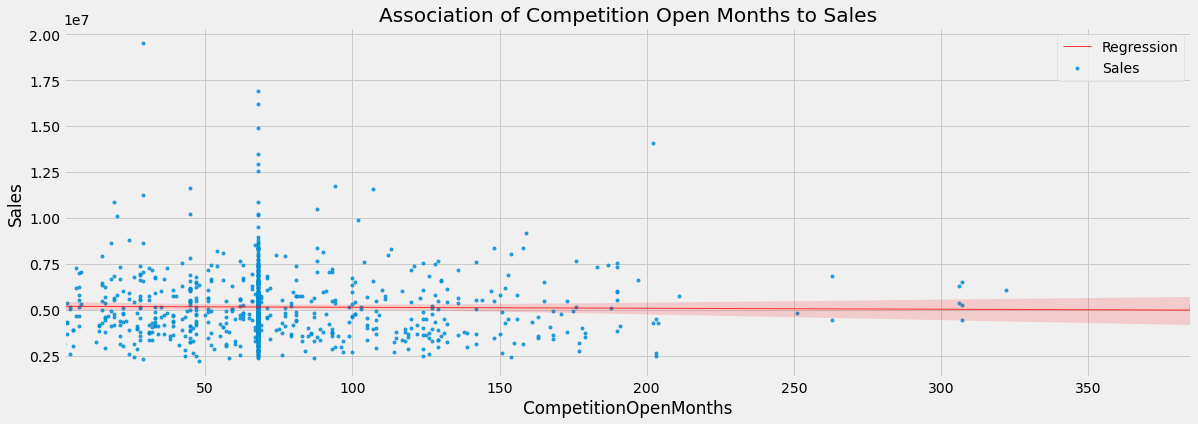

In [75]:
competition_months = train.groupby('store_id').agg({'Sales':'sum', 'CompetitionOpenMonths':'mean'})

plt.figure(figsize=(18, 6))
sns.regplot(x="CompetitionOpenMonths", y="Sales", 
            data=competition_months,
            marker='.',
            line_kws={'label':'Regression', 'color':'red', 'alpha':0.75, 'lw':1},
            label='Sales'
            )
plt.legend()
plt.title("Association of Competition Open Months to Sales")
plt.savefig("association_of_competition_months_with_sales.png", dpi=300, bbox_inches='tight');

#### 5.4 Analyze Stores

Pareto 80% - 20% Principle: False 
Fraction Of 80%: 69.74%


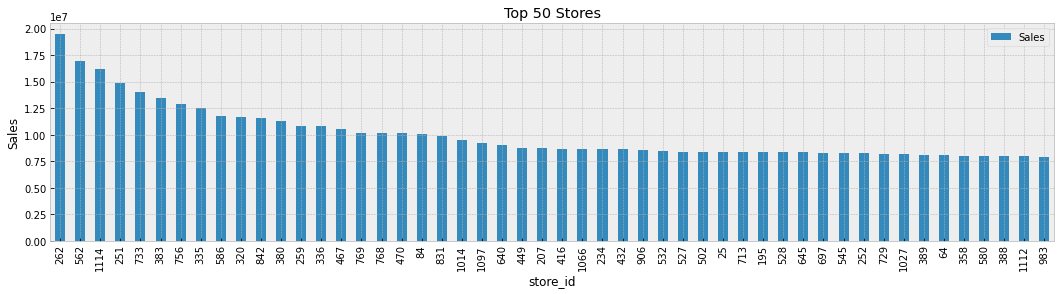

In [145]:
ranked_stores = train.groupby('store_id').agg({'Sales':'sum'}).sort_values('Sales', ascending=False)
ranked_stores[:50].plot(kind='bar', figsize=(18, 4))
plt.ylabel('Sales')
plt.title("Top 50 Stores");

pareto_rule = ranked_stores.cumsum() / ranked_stores.Sales.sum()
pareto_frac = pareto_rule[pareto_rule.Sales <= 0.80].shape[0] / pareto_rule.shape[0]
print("Pareto 80% - 20% Principle:",  pareto_frac <= 0.20, "\nFraction Of 80%: {:1.2%}".format(pareto_frac))
plt.savefig("top50_stores.png", dpi=300);

In [119]:
train

,store_id,DayOfWeek,Date,Sales,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,CompetitionOpenMonths,Promo2Weeks,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StoreTypeAssortment_a_a,StoreTypeAssortment_a_c,StoreTypeAssortment_b_a,StoreTypeAssortment_b_b,StoreTypeAssortment_b_c,StoreTypeAssortment_c_a,StoreTypeAssortment_c_c,StoreTypeAssortment_d_a,StoreTypeAssortment_d_c,Year,Month,Week,Day,IsPromo2,Store_1,Store_3,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,...,Store_1058,Store_1059,Store_1060,Store_1061,Store_1062,Store_1063,Store_1064,Store_1065,Store_1066,Store_1067,Store_1068,Store_1070,Store_1071,Store_1072,Store_1073,Store_1076,Store_1077,Store_1078,Store_1079,Store_1080,Store_1083,Store_1084,Store_1086,Store_1087,Store_1088,Store_1089,Store_1091,Store_1092,Store_1094,Store_1096,Store_1097,Store_1099,Store_1100,Store_1101,Store_1102,Store_1103,Store_1104,Store_1105,Store_1106,Store_1107,Store_1109,Store_1111,Store_1112,Store_1113,Store_1114,Store_1115,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,5,2015-07-31,5263.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,31,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1115,1,4,2015-07-30,5020.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2230,1,3,2015-07-29,4782.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,29,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3345,1,2,2015-07-28,5011.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4460,1,1,2015-07-27,6102.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,27,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012749,1115,6,2013-01-05,4771.0,1.0,0,1,5350.0,1,68.0,178.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1013864,1115,5,2013-01-04,4540.0,1.0,0,1,5350.0,1,68.0,178.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1014979,1115,4,2013-01-03,4297.0,1.0,0,1,5350.0,1,68.0,178.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1016094,1115,3,2013-01-02,3697.0,1.0,0,1,5350.0,1,68.0,178.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


#### 5.5 Paiplot

In [66]:
ppdf = pd.read_csv("train.csv", 
                   low_memory=False, 
                   parse_dates=['Date'],
                   date_parser=date_parser)

In [67]:
ppdf = ppdf.set_index('Date').resample('D').agg({'Sales':'sum', 'Customers':'sum', 
                                          'Open':'sum', 'Promo':'sum', 
                                          'StateHoliday':'sum',
                                          'SchoolHoliday':'sum'})

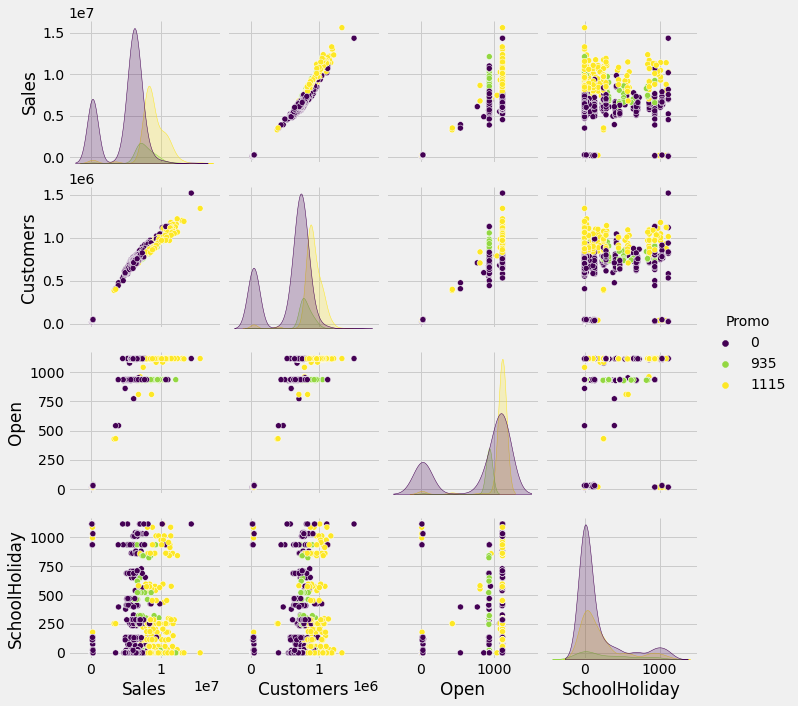

In [69]:
sns.pairplot(ppdf, hue='Promo', palette='viridis', )
plt.savefig('pairplot.png', dpi=300, bbox_inches='tight');

### 6. Correlation Analysis
- Correlation Analysis will reveal the most correlated variables to the target.
- Also will show possible multicollinearity problems.

In [77]:
nonstore_cols = [c for c in train.columns if not c.startswith("Store_") and not c.startswith('store')]

In [78]:
corr = train[nonstore_cols].corr()

In [87]:
# Top 10 most positively correlated variables to the target
pcorr = corr.sort_values('Sales', ascending=False)[['Sales']].drop('Sales').iloc[:10]
negcorr = corr.sort_values('Sales', ascending=True)[['Sales']].drop('Sales').iloc[:10]
pcorr

,Sales
Open,0.691086
Promo,0.446946
StateHoliday_0,0.263190
StoreType_b,0.165263
StoreTypeAssortment_b_a,0.150320
StoreTypeAssortment_b_c,0.115169
Assortment_b,0.080062
StoreTypeAssortment_b_b,0.080062
StoreTypeAssortment_a_c,0.078143
SchoolHoliday,0.077732


In [89]:
negcorr

,Sales
DayOfWeek,-0.452085
StateHoliday_a,-0.212240
StateHoliday_b,-0.120075
StateHoliday_c,-0.093307
Assortment_a,-0.082759
Promo2,-0.080929
StoreTypeAssortment_a_a,-0.068702
Promo2Weeks,-0.050632
StoreTypeAssortment_d_a,-0.040395
IsPromo2,-0.037938


In [91]:
excelwriter = pd.ExcelWriter('correlations.xlsx')
pcorr.to_excel(excelwriter, sheet_name='10positive')
negcorr.to_excel(excelwriter, sheet_name='10negative')
excelwriter.close()

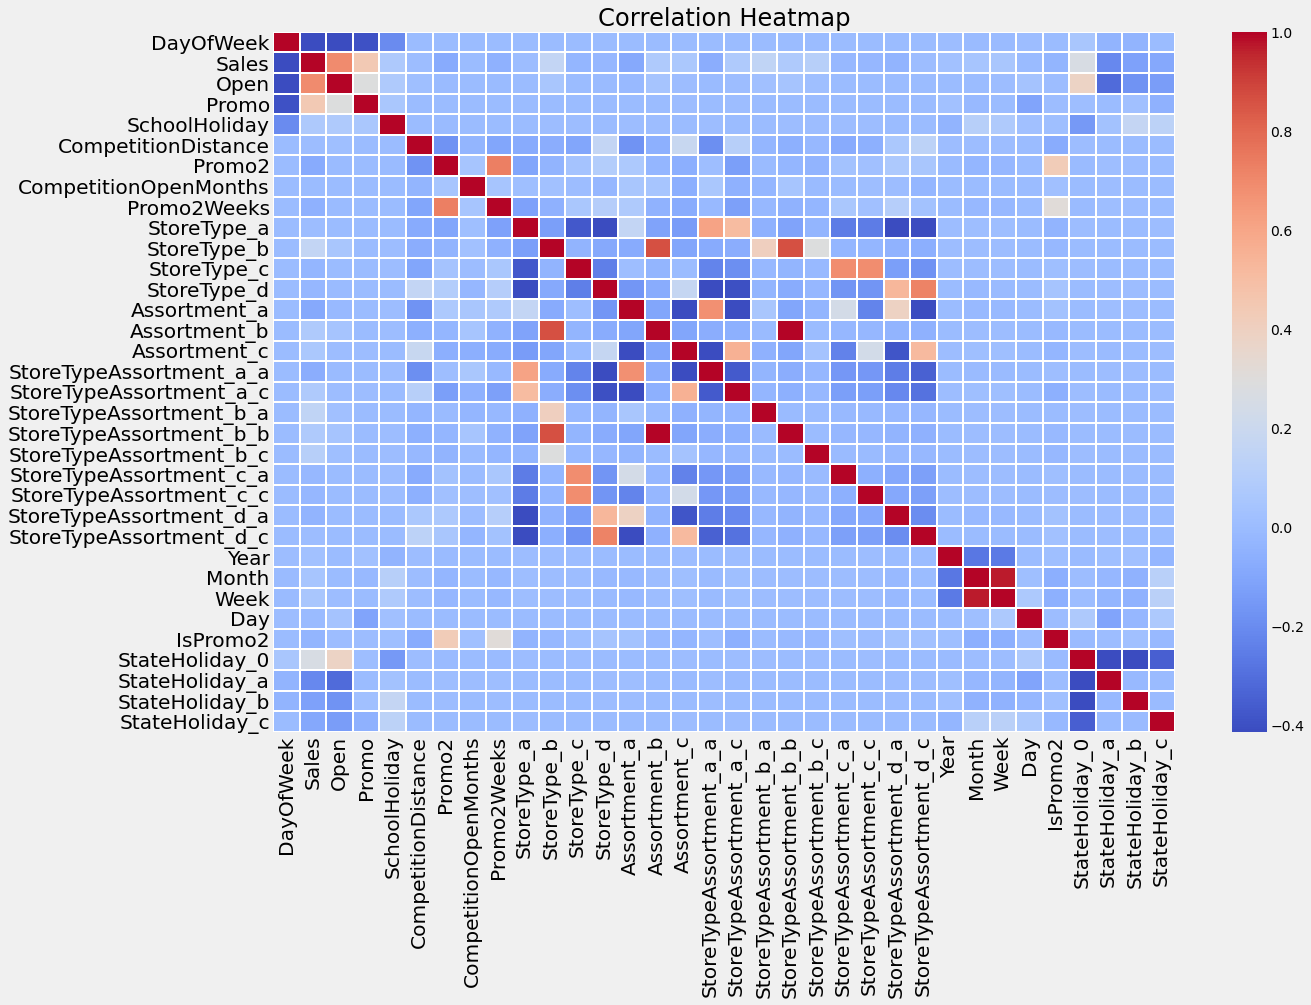

In [85]:
plt.figure(figsize=(18, 12))
sns.heatmap(corr, cmap='coolwarm', robust=True, linecolor='white', linewidths=1, square=False)
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.title("Correlation Heatmap", fontsize='xx-large')
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight');

### 7. Regression Analysis - Add Seasonality - Feature Selection
- To treat Memory Issues we are not going to use the one-hot-encoded stores in the analyses

In [92]:
import statsmodels.formula.api as smf

In [93]:
datasmf = train[nonstore_cols].drop(columns=['Date'])
datasmf.head()

,DayOfWeek,Sales,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,CompetitionOpenMonths,Promo2Weeks,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StoreTypeAssortment_a_a,StoreTypeAssortment_a_c,StoreTypeAssortment_b_a,StoreTypeAssortment_b_b,StoreTypeAssortment_b_c,StoreTypeAssortment_c_a,StoreTypeAssortment_c_c,StoreTypeAssortment_d_a,StoreTypeAssortment_d_c,Year,Month,Week,Day,IsPromo2,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,5,5263.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,31,0,1,0,0,0
1115,4,5020.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,30,0,1,0,0,0
2230,3,4782.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,29,0,1,0,0,0
3345,2,5011.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,28,0,1,0,0,0
4460,1,6102.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,27,0,1,0,0,0


#### 7.1 Regression Analysis 
- A Regression analysis will show the important variables.
- It will provide an idea of the data's predictability.
- It will reveal statistical issues.

In [94]:
formula = "Sales ~ {}".format(" + ".join(c for c in datasmf.columns if c!='Sales'))
formula

'Sales ~ DayOfWeek + Open + Promo + SchoolHoliday + CompetitionDistance + Promo2 + CompetitionOpenMonths + Promo2Weeks + StoreType_a + StoreType_b + StoreType_c + StoreType_d + Assortment_a + Assortment_b + Assortment_c + StoreTypeAssortment_a_a + StoreTypeAssortment_a_c + StoreTypeAssortment_b_a + StoreTypeAssortment_b_b + StoreTypeAssortment_b_c + StoreTypeAssortment_c_a + StoreTypeAssortment_c_c + StoreTypeAssortment_d_a + StoreTypeAssortment_d_c + Year + Month + Week + Day + IsPromo2 + StateHoliday_0 + StateHoliday_a + StateHoliday_b + StateHoliday_c'

In [95]:
ols = smf.ols(formula, datasmf).fit()

In [96]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                 4.755e+04
Date:                Mon, 15 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:07:08   Log-Likelihood:            -7.1045e+06
No. Observations:              773231   AIC:                         1.421e+07
Df Residuals:                  773206   BIC:                         1.421e+07
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 490.3339     10.815     45.339      0.000     469.137     511.531
DayOfWeek                -103.5526      1.763    -58.747      0.000    -107.007    -100.098
Open                     5533.7337      9.764    566.761      0.000    5514.597    5552.870
Promo                    1998.8346      6.132    325.965      0.000    1986.816    2010.853
SchoolHoliday              91.9659      7.482     12.291      0.000      77.301     106.631
CompetitionDistance        -0.0126      0.000    -32.412      0.000      -0.013      -0.012
Promo2                   -630.6160      8.514    -74.070      0.000    -647.303    -613.929
CompetitionOpenMonths       0.6854      0.059     11.711      0.000       0.571       0.800
Promo2Weeks                 1.2708      0.039     32.465      0.000       1.194       1.348
StoreType_a             -1390.8689      7.183   -193.643      0.000   -1404.947   -1376.791
StoreType_b              5021.8721     21.711    231.308      0.000    4979.320    5064.424
StoreType_c             -1642.4970      8.152   -201.496      0.000   -1658.474   -1626.520
StoreType_d             -1498.1724      7.441   -201.336      0.000   -1512.757   -1483.588
Assortment_a             1075.1027     11.207     95.930      0.000    1053.137    1097.068
Assortment_b            -2014.3021     15.502   -129.938      0.000   -2044.686   -1983.919
Assortment_c             1429.5332     14.594     97.952      0.000    1400.929    1458.137
StoreTypeAssortment_a_a  -939.3698      9.700    -96.844      0.000    -958.381    -920.358
StoreTypeAssortment_a_c  -451.4991     11.639    -38.792      0.000    -474.311    -428.687
StoreTypeAssortment_b_a  3357.5721     36.070     93.086      0.000    3286.877    3428.267
StoreTypeAssortment_b_b -2014.3021     15.502   -129.938      0.000   -2044.686   -1983.919
StoreTypeAssortment_b_c  3678.6021     46.193     79.636      0.000    3588.066    3769.138
StoreTypeAssortment_c_a  -561.2142     11.462    -48.962      0.000    -583.680    -538.748
StoreTypeAssortment_c_c -1081.2828     13.100    -82.543      0.000   -1106.958   -1055.608
StoreTypeAssortment_d_a  -781.8854     10.168    -76.894      0.000    -801.815    -761.956
StoreTypeAssortment_d_c  -716.2870     11.779    -60.808      0.000    -739.374    -693.200
Year                      182.4536      3.585     50.901      0.000     175.428     189.479
Month                      71.3813      3.355     21.279      0.000      64.806      77.956
Week                       -1.9379      0.770     -2.517      0.012      -3.447      -0.429
Day                        -2.0822      0.320     -6.502      0.000      -2.710      -1.454
IsPromo2                  -60.0950      7.536     -7.974      0.000     -74.866     -45.325
StateHoliday_0            892.4958     15.019  

#### 7.2 Add Seasonality
- Add polynomial features of datetime features.

In [97]:
datefeats = datasmf[['DayOfWeek', 'Year', 'Month', 'Week', 'Day']]
datefeats_squared = datefeats.apply(np.square).add_suffix('_squared')
datefeats_cubed = (datefeats**3).add_suffix('_cubed')
datefeats_quart = (datefeats**4).add_suffix('_quart')
data_poly = datasmf.join([datefeats_squared, datefeats_cubed, datefeats_quart])
data_poly.head()

,DayOfWeek,Sales,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,CompetitionOpenMonths,Promo2Weeks,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StoreTypeAssortment_a_a,StoreTypeAssortment_a_c,StoreTypeAssortment_b_a,StoreTypeAssortment_b_b,StoreTypeAssortment_b_c,StoreTypeAssortment_c_a,StoreTypeAssortment_c_c,StoreTypeAssortment_d_a,StoreTypeAssortment_d_c,Year,Month,Week,Day,IsPromo2,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,DayOfWeek_squared,Year_squared,Month_squared,Week_squared,Day_squared,DayOfWeek_cubed,Year_cubed,Month_cubed,Week_cubed,Day_cubed,DayOfWeek_quart,Year_quart,Month_quart,Week_quart,Day_quart
0,5,5263.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,31,0,1,0,0,0,25,4,49,961,961,125,8,343,29791,29791,625,16,2401,923521,923521
1115,4,5020.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,30,0,1,0,0,0,16,4,49,961,900,64,8,343,29791,27000,256,16,2401,923521,810000
2230,3,4782.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,29,0,1,0,0,0,9,4,49,961,841,27,8,343,29791,24389,81,16,2401,923521,707281
3345,2,5011.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,28,0,1,0,0,0,4,4,49,961,784,8,8,343,29791,21952,16,16,2401,923521,614656
4460,1,6102.0,1.0,1,1,1270.0,0,93.0,39.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,7,31,27,0,1,0,0,0,1,4,49,961,729,1,8,343,29791,19683,1,16,2401,923521,531441


In [98]:
data_poly.shape

(773231, 49)

#### 7.3 Lasso Feature Selection
- We going to select the most predictable features of Sales using Lasso with Cross-Validation 

In [99]:
X = data_poly.drop(columns=['Sales'])
y = data_poly['Sales']

In [100]:
from sklearn.linear_model import LassoLarsCV

In [101]:
lasso = LassoLarsCV(max_iter=10000, cv=10).fit(X, y)

In [102]:
lasso.score(X, y)

0.6226827844637548

In [103]:
feature_selection = X.columns[np.nonzero(lasso.coef_)[0]].to_list()
dropped_feats = set(X.columns) - set(feature_selection)
print(dropped_feats)

{'StoreTypeAssortment_b_b', 'StoreType_d', 'StoreTypeAssortment_d_c', 'Assortment_b', 'StoreType_a', 'Year_squared', 'StateHoliday_a', 'StoreType_c', 'StoreTypeAssortment_d_a', 'Year_cubed', 'Assortment_c'}


In [104]:
data_fs = data_poly.drop(columns=dropped_feats)
formula2 = "Sales ~ {}".format(' + '.join(data_fs.drop(columns='Sales').columns))
model_fs = smf.ols(formula2, data_fs).fit()
print("Formula:", formula2)

Formula: Sales ~ DayOfWeek + Open + Promo + SchoolHoliday + CompetitionDistance + Promo2 + CompetitionOpenMonths + Promo2Weeks + StoreType_b + Assortment_a + StoreTypeAssortment_a_a + StoreTypeAssortment_a_c + StoreTypeAssortment_b_a + StoreTypeAssortment_b_c + StoreTypeAssortment_c_a + StoreTypeAssortment_c_c + Year + Month + Week + Day + IsPromo2 + StateHoliday_0 + StateHoliday_b + StateHoliday_c + DayOfWeek_squared + Month_squared + Week_squared + Day_squared + DayOfWeek_cubed + Month_cubed + Week_cubed + Day_cubed + DayOfWeek_quart + Year_quart + Month_quart + Week_quart + Day_quart


In [105]:
model_fs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                 3.449e+04
Date:                Mon, 15 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:08:30   Log-Likelihood:            -7.0782e+06
No. Observations:              773231   AIC:                         1.416e+07
Df Residuals:                  773193   BIC:                         1.416e+07
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2636.9400     58.040     45.433      0.000    2523.184    2750.696
DayOfWeek               -2747.3648     72.643    -37.820      0.000   -2889.742   -2604.987
Open                     6112.1392     30.616    199.637      0.000    6052.132    6172.146
Promo                    2115.9982      6.253    338.384      0.000    2103.742    2128.254
SchoolHoliday             198.3640      7.705     25.745      0.000     183.262     213.466
CompetitionDistance        -0.0131      0.000    -34.723      0.000      -0.014      -0.012
Promo2                   -653.7953      8.236    -79.382      0.000    -669.938    -637.653
CompetitionOpenMonths       0.7006      0.057     12.385      0.000       0.590       0.812
Promo2Weeks                 1.2764      0.038     33.737      0.000       1.202       1.351
StoreType_b              1683.3578     26.419     63.719      0.000    1631.578    1735.137
Assortment_a             -422.5326      9.252    -45.668      0.000    -440.667    -404.399
StoreTypeAssortment_a_a   -49.1278      8.817     -5.572      0.000     -66.408     -31.848
StoreTypeAssortment_a_c   372.5406      7.848     47.471      0.000     357.159     387.922
StoreTypeAssortment_b_a  8882.2291     59.173    150.105      0.000    8766.251    8998.207
StoreTypeAssortment_b_c  9129.4092     78.694    116.011      0.000    8975.171    9283.647
StoreTypeAssortment_c_a    79.5948     13.552      5.873      0.000      53.034     106.156
StoreTypeAssortment_c_c  -507.5031     12.772    -39.735      0.000    -532.536    -482.470
Year                      150.0066      6.628     22.631      0.000     137.015     162.998
Month                    1365.5703     50.907     26.825      0.000    1265.794    1465.346
Week                     -307.7980      8.703    -35.366      0.000    -324.856    -290.740
Day                      -405.1546      6.894    -58.767      0.000    -418.667    -391.642
IsPromo2                   -8.0415      7.325     -1.098      0.272     -22.398       6.315
StateHoliday_0            789.1471     35.076     22.498      0.000     720.400     857.895
StateHoliday_b           -712.4333     37.999    -18.749      0.000    -786.910    -637.956
StateHoliday_c           -578.6238     49.142    -11.775      0.000    -674.940    -482.308
DayOfWeek_squared         715.0514     35.693     20.033      0.000     645.094     785.009
Month_squared            -448.5106     17.012    -26.365      0.000    -481.853    -415.168
Week_squared               32.0978      0.751     42.757      0.000      30.626      33.569
Day_squared                49.5977      0.859     57.761      0.000      47.915      51.281
DayOfWeek_cubed           -67.6666      6.961     -9.721      0.000     -81.310     -54.023
Month_cubed                47.3694      2.067  

#### 7.4 Final Feature Selection
- Drop also the insignificant features from the last regression analysis.
- Standardize the numbers of the data according to the Normal distribution
- Run a Final Analysis to confirm the results 

In [106]:
drop_insignifcant = ['Year_quart', 'IsPromo2',]
data_fs2 = data_fs.drop(columns=drop_insignifcant)

In [107]:
X = data_fs2.drop(columns=['Sales'])
y = data_fs2['Sales']

In [108]:
scaler = StandardScaler()
data_fs2_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index).join(y)

In [109]:
data_fs2_scaled.head()

,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,CompetitionOpenMonths,Promo2Weeks,StoreType_b,Assortment_a,StoreTypeAssortment_a_a,StoreTypeAssortment_a_c,StoreTypeAssortment_b_a,StoreTypeAssortment_b_c,StoreTypeAssortment_c_a,StoreTypeAssortment_c_c,Year,Month,Week,Day,StateHoliday_0,StateHoliday_b,StateHoliday_c,DayOfWeek_squared,Month_squared,Week_squared,Day_squared,DayOfWeek_cubed,Month_cubed,Week_cubed,Day_cubed,DayOfWeek_quart,Month_quart,Week_quart,Day_quart,Sales
0,0.501407,0.452148,1.273791,2.150375,-0.526516,-1.147484,0.367737,-0.841682,-0.120793,1.024379,-0.663143,-0.556082,-0.049421,-0.034925,4.240572,-0.235187,1.497142,0.358493,0.523535,1.741051,0.17895,-0.081772,-0.063074,0.307191,0.098205,0.266372,2.234664,0.112307,-0.109855,0.037595,2.638953,-0.050164,-0.247187,-0.127148,2.985730,5263.0
1115,0.000758,0.452148,1.273791,2.150375,-0.526516,-1.147484,0.367737,-0.841682,-0.120793,1.024379,-0.663143,-0.556082,-0.049421,-0.034925,4.240572,-0.235187,1.497142,0.358493,0.523535,1.627246,0.17895,-0.081772,-0.063074,-0.243278,0.098205,0.266372,2.020755,-0.406538,-0.109855,0.037595,2.308333,-0.497131,-0.247187,-0.127148,2.526077,5020.0
2230,-0.499892,0.452148,1.273791,2.150375,-0.526516,-1.147484,0.367737,-0.841682,-0.120793,1.024379,-0.663143,-0.556082,-0.049421,-0.034925,4.240572,-0.235187,1.497142,0.358493,0.523535,1.513441,0.17895,-0.081772,-0.063074,-0.671421,0.098205,0.266372,1.813859,-0.721247,-0.109855,0.037595,1.999036,-0.709108,-0.247187,-0.127148,2.110161,4782.0
3345,-1.000542,0.452148,1.273791,2.150375,-0.526516,-1.147484,0.367737,-0.841682,-0.120793,1.024379,-0.663143,-0.556082,-0.049421,-0.034925,4.240572,-0.235187,1.497142,0.358493,0.523535,1.399636,0.17895,-0.081772,-0.063074,-0.977237,0.098205,0.266372,1.613976,-0.882855,-0.109855,0.037595,1.710350,-0.787842,-0.247187,-0.127148,1.735117,5011.0
4460,-1.501191,0.452148,1.273791,2.150375,-0.526516,-1.147484,0.367737,-0.841682,-0.120793,1.024379,-0.663143,-0.556082,-0.049421,-0.034925,4.240572,-0.235187,1.497142,0.358493,0.523535,1.285831,0.17895,-0.081772,-0.063074,-1.160726,0.098205,0.266372,1.421107,-0.942395,-0.109855,0.037595,1.441566,-0.806011,-0.247187,-0.127148,1.398175,6102.0


In [110]:
formula2 = "Sales ~ {}".format(' + '.join(X.columns))
model_fs2 = smf.ols(formula2, data_fs2).fit()
print("Formula:", formula2)

Formula: Sales ~ DayOfWeek + Open + Promo + SchoolHoliday + CompetitionDistance + Promo2 + CompetitionOpenMonths + Promo2Weeks + StoreType_b + Assortment_a + StoreTypeAssortment_a_a + StoreTypeAssortment_a_c + StoreTypeAssortment_b_a + StoreTypeAssortment_b_c + StoreTypeAssortment_c_a + StoreTypeAssortment_c_c + Year + Month + Week + Day + StateHoliday_0 + StateHoliday_b + StateHoliday_c + DayOfWeek_squared + Month_squared + Week_squared + Day_squared + DayOfWeek_cubed + Month_cubed + Week_cubed + Day_cubed + DayOfWeek_quart + Month_quart + Week_quart + Day_quart


In [111]:
X.shape

(773231, 35)

In [112]:
model_fs2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                 3.646e+04
Date:                Mon, 15 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:08:34   Log-Likelihood:            -7.0782e+06
No. Observations:              773231   AIC:                         1.416e+07
Df Residuals:                  773195   BIC:                         1.416e+07
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2635.1186     58.002     45.431      0.000    2521.436    2748.801
DayOfWeek               -2747.2620     72.643    -37.819      0.000   -2889.639   -2604.885
Open                     6111.8626     30.615    199.635      0.000    6051.858    6171.867
Promo                    2115.9882      6.253    338.382      0.000    2103.732    2128.244
SchoolHoliday             198.3000      7.704     25.740      0.000     183.200     213.400
CompetitionDistance        -0.0131      0.000    -34.724      0.000      -0.014      -0.012
Promo2                   -656.6235      7.839    -83.760      0.000    -671.988    -641.259
CompetitionOpenMonths       0.7006      0.057     12.385      0.000       0.590       0.811
Promo2Weeks                 1.2766      0.038     33.740      0.000       1.202       1.351
StoreType_b              1683.4338     26.418     63.722      0.000    1631.654    1735.213
Assortment_a             -422.5501      9.252    -45.671      0.000    -440.684    -404.416
StoreTypeAssortment_a_a   -49.1315      8.816     -5.573      0.000     -66.412     -31.851
StoreTypeAssortment_a_c   372.5754      7.848     47.477      0.000     357.195     387.956
StoreTypeAssortment_b_a  8882.2006     59.173    150.105      0.000    8766.223    8998.178
StoreTypeAssortment_b_c  9129.4008     78.694    116.011      0.000    8975.163    9283.639
StoreTypeAssortment_c_a    79.6158     13.551      5.875      0.000      53.055     106.176
StoreTypeAssortment_c_c  -507.4379     12.772    -39.731      0.000    -532.470    -482.406
Year                      147.7343      3.508     42.118      0.000     140.859     154.609
Month                    1367.7542     50.872     26.886      0.000    1268.047    1467.462
Week                     -307.8216      8.703    -35.369      0.000    -324.879    -290.764
Day                      -405.1480      6.894    -58.766      0.000    -418.660    -391.636
StateHoliday_0            789.3038     35.075     22.503      0.000     720.557     858.051
StateHoliday_b           -713.5965     37.985    -18.786      0.000    -788.045    -639.148
StateHoliday_c           -578.5050     49.141    -11.772      0.000    -674.821    -482.189
DayOfWeek_squared         714.9330     35.693     20.030      0.000     644.976     784.890
Month_squared            -449.0230     17.006    -26.404      0.000    -482.354    -415.692
Week_squared               32.0964      0.751     42.758      0.000      30.625      33.568
Day_squared                49.5964      0.859     57.759      0.000      47.913      51.279
DayOfWeek_cubed           -67.6331      6.961     -9.716      0.000     -81.277     -53.990
Month_cubed                47.4184      2.067     22.942      0.000      43.367      51.469
Week_cubed                 -1.0076      0.023  

### 6. Model Selection 
- To train and optimize the model, we are going to use Ridge Regression using:
    - a 10-fold cross-validation
    - 8 regularization values.
- To evaluate how well the model can predict future we will use a one month validation set drawn from the train set.
    - This training set MUST NOT contain information from the future so the validation set will be the last month's obervations meaning the July of 2015.  

In [113]:
store_cols = [c for c in train.columns if c.startswith('Store_')]
store_ids = train[store_cols]
df = store_ids.join(data_fs2)
validation_index = train[train.Date=='2015-07'].index
validset = df.loc[validation_index]
trainset = df.drop(validation_index)

In [114]:
# Important: Save files when reaching this section
try:
    os.mkdir('data_safe')
except FileExistsError:
    pass
finally:
    validset.to_csv("data_safe/validset.csv")
    trainset.to_csv("data_safe/trainset.csv")
    test.to_csv("data_safe/test.csv")

In [115]:
validset = pd.read_csv("data_safe/validset.csv", index_col=0)
trainset = pd.read_csv("data_safe/trainset.csv", index_col=0)
test = pd.read_csv("data_safe/test.csv", index_col=0)

# Important:
# if Memory Error occurs during training
# Restart Notebook, 
# Run imports, 
# load above files and start from here 

In [116]:
validset.shape

(856, 892)

In [4]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    rmspe = root_mean_squared_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return pd.Series(dict(mae=mae, mape=mape, rmse=rmse, rmspe=rmspe, r2=r2))

In [5]:
validset.shape, trainset.shape, test.shape

((856, 892), (772375, 892), (41088, 892))

In [6]:
X_train, X_valid = trainset.drop(columns=['Sales']).astype(np.float32), validset.drop(columns='Sales')
y_train, y_valid = trainset['Sales'], validset['Sales']

In [7]:
lr = LinearRegression(n_jobs=-1).fit(X_train, y_train)

In [8]:
print("Train Score:", lr.score(X_train, y_train))

Train Score: 0.5834530905433846


In [9]:
evaluate(lr, X_valid, y_valid)

mae      2149.387704
mape       31.935163
rmse     2762.277212
rmspe      43.110190
r2         -0.014130
dtype: float64

In [10]:
alphas=[1e-7, 1e-6, 1e-5] 
# when rerun choose alphas = [1e-7, 1e-6, 1e-5]
ridge = RidgeCV(alphas=alphas, cv=10, normalize=True).fit(X_train, y_train)

C:\Users\yiorg\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.5791e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [11]:
ridge.score(X_train, y_train)

0.841315416866424

In [12]:
ridge.alpha_

1e-05

In [13]:
evaluate(ridge, X_valid, y_valid)

mae      1101.776805
mape       16.804365
rmse     1393.019962
rmspe      23.963954
r2          0.742087
dtype: float64

In [14]:
coefs = pd.Series(ridge.coef_, index=X_train.columns)

In [15]:
y_pred_valid = ridge.predict(X_valid)

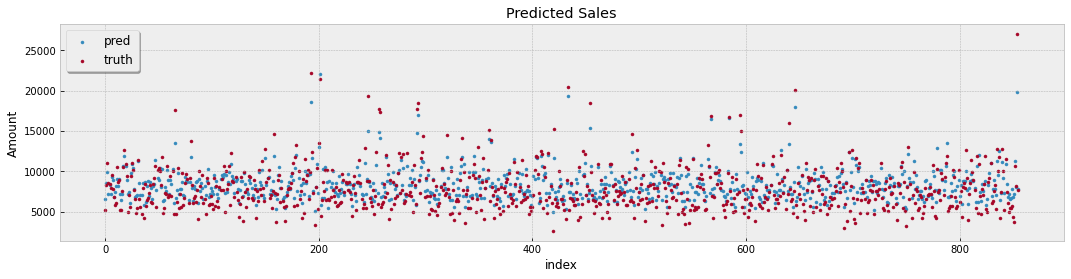

In [16]:
plt.figure(figsize=(18, 4))
plt.scatter(np.arange(len(y_pred_valid)), y_pred_valid, marker='.', label='pred')
plt.scatter(np.arange(len(y_pred_valid)), y_valid, marker='.', label='truth')
plt.legend(fontsize='large', shadow=True, fancybox=True)
plt.xlabel('index')
plt.ylabel('Amount')
plt.title("Predicted Sales")
plt.savefig("predicted_sales_vs_true_sales.png");

#### 6.1 Residuals

In [17]:
y_pred = ridge.predict(X_valid)
resid = y_valid - y_pred
resid_lr = LinearRegression().fit(y_pred.reshape(-1, 1), resid)
resid_reg = resid_lr.predict(y_pred.reshape(-1, 1))

In [18]:
resid.mean()

-544.1728408209475

In [19]:
resid_lr.coef_, resid_lr.intercept_

(array([0.29807602]), -3043.029438913686)

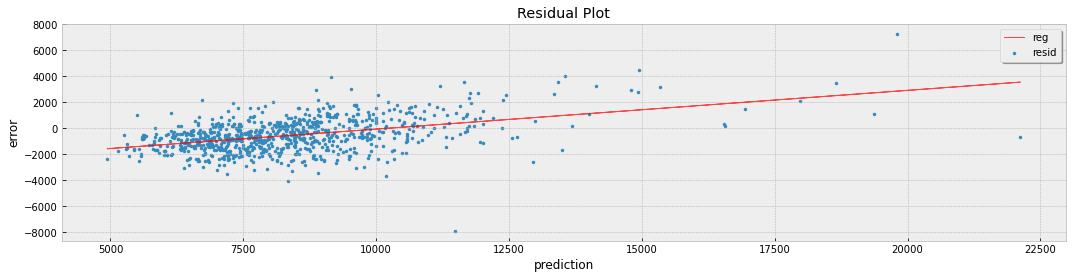

In [20]:
plt.figure(figsize=(18, 4))
plt.scatter(y_pred, resid, marker='.', label='resid')
plt.plot(y_pred, resid_reg, label='reg', color='red', alpha=0.70, lw=1)
plt.legend(shadow=True, fancybox=True)
plt.ylabel('error')
plt.xlabel('prediction')
plt.title("Residual Plot");

#### 6.2 Feature Importance

In [21]:
idx1 = (coefs.
         apply(abs).
         sort_values(ascending=False).
         drop([idx for idx in coefs.index if idx.startswith('Store_')])).index

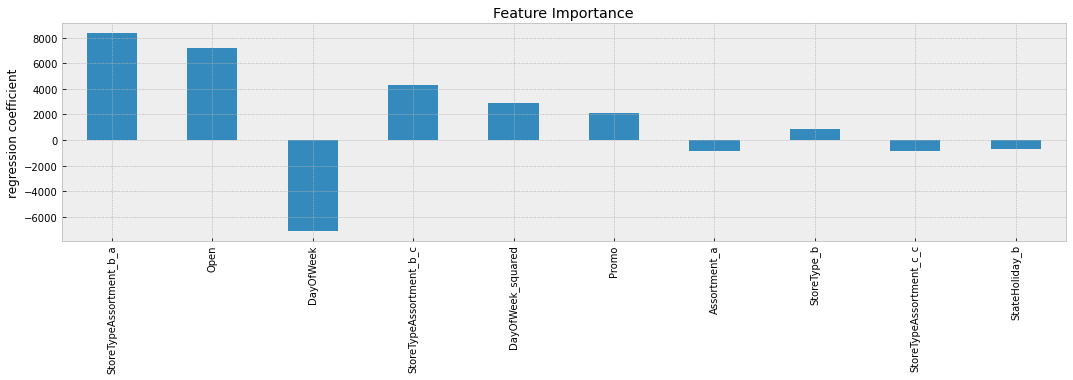

In [23]:
coefs.loc[idx1][:10].plot(kind='bar', figsize=(18, 4),)
plt.ylabel("regression coefficient")
plt.title("Feature Importance")
plt.savefig("feature_importance.png");

### 7. Predict
- To bring the test data into a predict structure we have to:
    - add the seasonality,
    - select features,
    - bring the matrix columns into the correct order,
- Make the prediction using the selected model.
- Check Prediction for impossible or unprobable values and adjust them e.g sales < 0

In [24]:
datefeats = test[['Year', 'Month', 'Week', 'Day', 'DayOfWeek']]

In [25]:
squared = datefeats.apply(np.square).add_suffix("_squared")
cubed = (datefeats**3).add_suffix("_cubed")
quart = (datefeats**4).add_suffix("_quart")

In [26]:
testset = test.join([squared, cubed, quart])

In [27]:
X_test = testset[X_train.columns]  # Feature selection from train columns

In [28]:
testset['Sales'] = ridge.predict(X_test)

In [29]:
submission = testset[['store_id', 'Date', 'Sales']].rename(columns={'store_id':'Store'}).reset_index(drop=True)

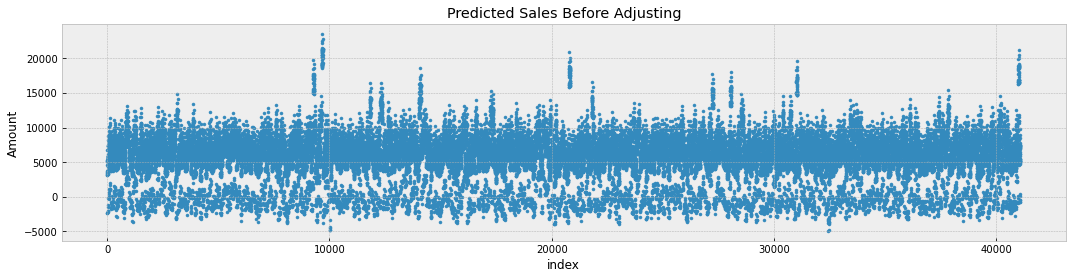

In [30]:
plt.figure(figsize=(18, 4))
plt.scatter(np.arange(len(submission)), submission.Sales.values, marker='.')
plt.xlabel('index')
plt.ylabel('Amount')
plt.title("Predicted Sales Before Adjusting");

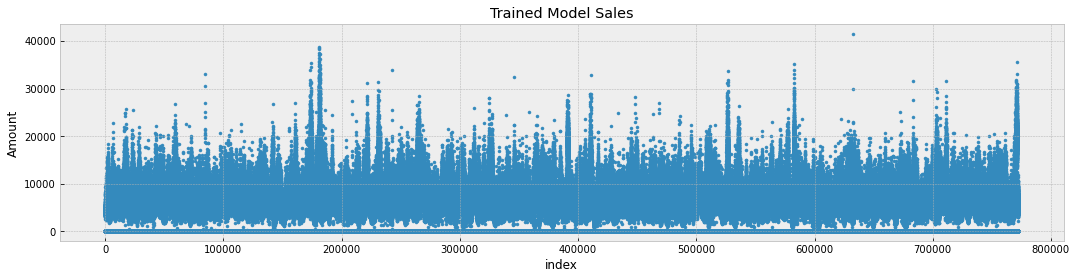

In [31]:
plt.figure(figsize=(18, 4))
plt.scatter(np.arange(len(y_train)), y_train.values, marker='.')
plt.xlabel('index')
plt.ylabel('Amount')
plt.title("Trained Model Sales");

In [32]:
y_train.describe()

count    772375.000000
mean       5688.697675
std        3723.689006
min           0.000000
25%        3776.000000
50%        5697.000000
75%        7722.000000
max       41551.000000
Name: Sales, dtype: float64

In [33]:
submission.Sales.describe()

count    41088.000000
mean      5691.206482
std       3307.587636
min      -4997.445321
25%       4291.769715
50%       6030.384359
75%       7641.373305
max      23563.406078
Name: Sales, dtype: float64

In [34]:
(y_train <= 0).sum() / (y_train > 0).sum() # values portion <= zero - train set

0.20479155682700917

In [36]:
(submission.Sales <= 0).sum() / (submission.Sales> 0).sum() # values portion <= zero predicted

0.09822788870178815

In [37]:
submission.Sales = (submission.Sales + (y_train.mean() - submission.Sales.mean())).clip(lower=0)

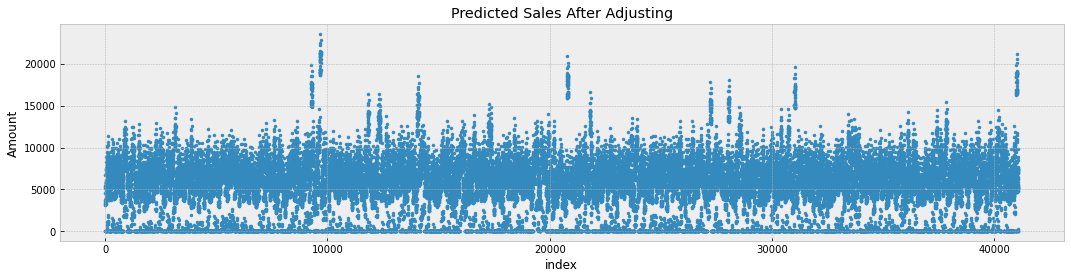

In [48]:
plt.figure(figsize=(18, 4))
plt.scatter(np.arange(len(submission)), submission.Sales.values, marker='.')
plt.xlabel('index')
plt.ylabel('Amount')
plt.title("Predicted Sales After Adjusting")
plt.savefig("predicted_sales_adjusted.png", dpi=300);

In [39]:
submission.Sales.describe()

count    41088.000000
mean      5807.035424
std       3059.042967
min          0.000000
25%       4289.260908
50%       6027.875552
75%       7638.864498
max      23560.897271
Name: Sales, dtype: float64

In [40]:
test_ = pd.read_csv("test.csv", low_memory=False, date_parser=date_parser, parse_dates=['Date'])
test_.drop(columns=['Sales', 'Customers'], inplace=True)

In [45]:
submission['Date'] = submission.Date.apply(pd.to_datetime)

In [46]:
result = test_.merge(submission, on=['Store', 'Date'])
result.to_csv("predicted_sales.csv")
result

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Sales
0,1,4,2015-09-17,1.0,1,0,0,5389.546334
1,3,4,2015-09-17,1.0,1,0,0,7530.213634
2,7,4,2015-09-17,1.0,1,0,0,8767.680559
3,8,4,2015-09-17,1.0,1,0,0,6036.438693
4,9,4,2015-09-17,1.0,1,0,0,6888.878773
...,...,...,...,...,...,...,...,...
41083,1111,6,2015-08-01,1.0,0,0,0,5223.750200
41084,1112,6,2015-08-01,1.0,0,0,0,9016.311427
41085,1113,6,2015-08-01,1.0,0,0,0,5975.641519
41086,1114,6,2015-08-01,1.0,0,0,0,17649.656787


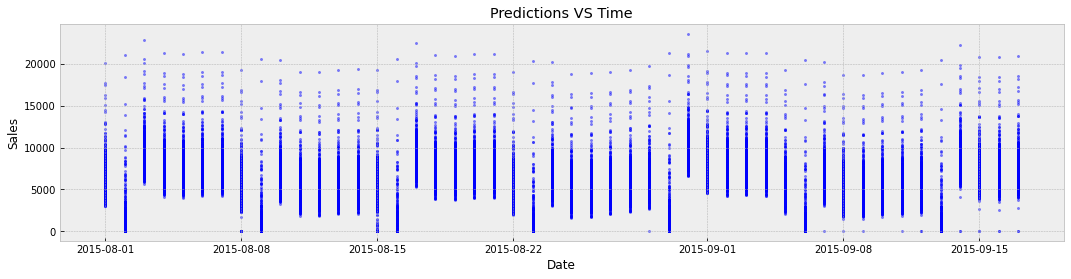

In [47]:
result.plot(kind='scatter', x='Date', y='Sales', figsize=(18,4), alpha=0.50, marker='.')
plt.ylabel('Sales')
plt.title('Predictions VS Time')
plt.savefig("predictions_vs_datetime.png", dpi=300);